In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

#Measurement.__dict__
#Station.__dict__


In [9]:
Measurement.__dict__

mappingproxy({'__table__': Table('measurement', MetaData(bind=None), Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False), Column('station', TEXT(), table=<measurement>), Column('date', TEXT(), table=<measurement>), Column('prcp', FLOAT(), table=<measurement>), Column('tobs', FLOAT(), table=<measurement>), schema=None),
              '__module__': 'sqlalchemy.ext.automap',
              '__doc__': None,
              '_sa_class_manager': <ClassManager of <class 'sqlalchemy.ext.automap.measurement'> at 16db849a3a8>,
              '__init__': <function __init__(self, **kwargs)>,
              'id': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x16db849a588>,
              'station': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x16db849a648>,
              'date': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x16db849a708>,
              'prcp': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x16db849a7c8>,
              'tobs': <sqlalc

In [10]:
Station.__dict__

mappingproxy({'__table__': Table('station', MetaData(bind=None), Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False), Column('station', TEXT(), table=<station>), Column('name', TEXT(), table=<station>), Column('latitude', FLOAT(), table=<station>), Column('longitude', FLOAT(), table=<station>), Column('elevation', FLOAT(), table=<station>), schema=None),
              '__module__': 'sqlalchemy.ext.automap',
              '__doc__': None,
              '_sa_class_manager': <ClassManager of <class 'sqlalchemy.ext.automap.station'> at 16db849a948>,
              '__init__': <function __init__(self, **kwargs)>,
              'id': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x16db849aa68>,
              'station': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x16db849ab28>,
              'name': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x16db849abe8>,
              'latitude': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x16db849aca8

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
last_date
print(last_date)

start_date = dt.datetime.strptime(last_date, "%Y-%m-%d") - dt.timedelta(366)
start_date
print(start_date)


2017-08-23
2016-08-22 00:00:00


In [13]:
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= start_date).all()
results[0:5]

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0)]

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(results, columns=["Date", "Precipitation"]).set_index("Date")
precip_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [15]:
# Sort the dataframe by date
precip_df_sorted = precip_df.sort_index(axis=0, ascending=True)
precip_df_sorted.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


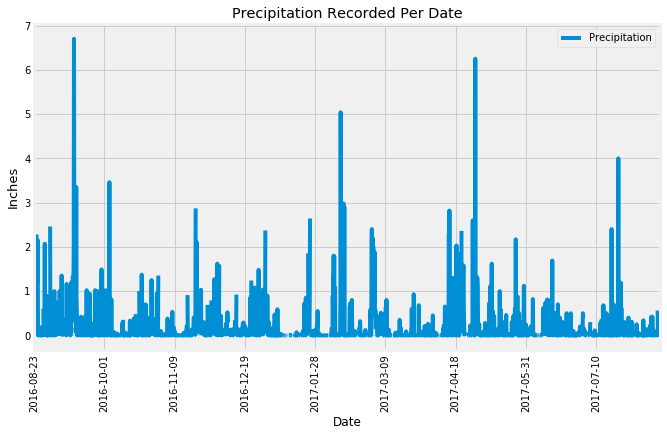

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data

#fig = plt.figure(figsize=(10,7))

#plt.plot(precip_df_sorted["Date"], precip_df_sorted["PRCP"])
precip_df_sorted.plot(y="Precipitation", kind="line", figsize=(10,6))
plt.title("Precipitation Recorded Per Date")
plt.xticks(rotation=90)
plt.ylabel("Inches", size=13)
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df_sorted.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(Measurement.station).distinct().count()
num_stations

9

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_results = session.query(Measurement.station, func.count(Measurement.station)).\
                group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_results


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_id = station_results[0][0]
most_active_station = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                filter(Measurement.station == most_active_id).all()
most_active_station
print(f"The most active station is {most_active_id}")
print(f"The lowest temperature recorded here was {most_active_station[0][0]}")
print(f"The highest temperature recorded here was {most_active_station[0][1]}")
print(f"The average temperature recorded here was {round(most_active_station[0][2],1)}")

The most active station is USC00519281
The lowest temperature recorded here was 54.0
The highest temperature recorded here was 85.0
The average temperature recorded here was 71.7


In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_results = session.query(Measurement.station, Measurement.tobs).filter(Measurement.station == most_active_id).\
                filter(Measurement.date >= start_date).all()
temp_results

temp_df = pd.DataFrame(temp_results, columns=["Station", "Temp Observations"]).set_index("Station")
temp_df.head()

,Temp Observations
Station,
USC00519281,77.0
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0


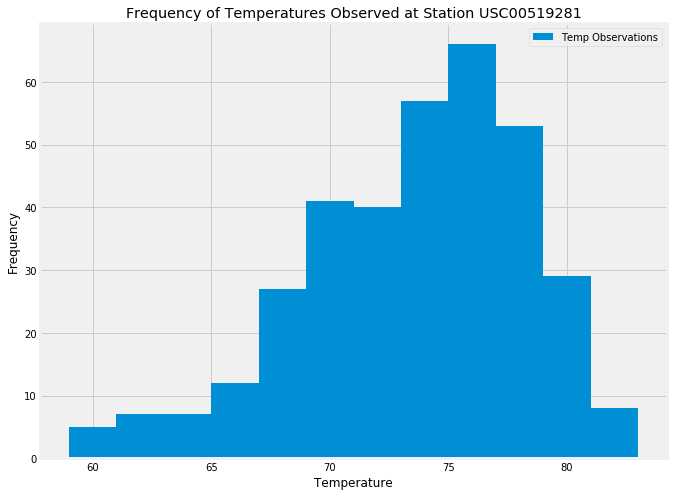

In [22]:
#Plot the results as a histogram with 12 bins
temp_df.plot.hist(by="station", bins=12, figsize=(10,8))
plt.title(f"Frequency of Temperatures Observed at Station {most_active_id}")
plt.xlabel("Temperature")
plt.show()

## Bonus Challenge Assignment

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [26]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [28]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [29]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [30]:
# Plot the daily normals as an area plot with `stacked=False`
